In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, cohen_kappa_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/adwiz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/adwiz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df = pd.read_json('../datasets/dataset.json')
df.rename(columns={"hasBadWords": "labels"}, inplace=True)
mapping = {False: 0.0, True: 1.0}
df.replace({'labels': mapping}, inplace=True)
df.drop(['violation'], axis=1, inplace=True)
df['text'] = df['text'].apply(lambda x: str(x))
df['labels'] = df['labels'].astype('category')
print('dimension: ', df.shape)
df.head()

dimension:  (86439, 2)


,text,labels
0,My Favorite Slut,0.0
1,girlfriends sit on each other's faces with the...,0.0
2,bound beauty kisses her girlfriend,0.0
3,MORGAN - Anytime - Nail Painting On The Slave'...,0.0
4,TRANSGENDER COACHING (wmv) PART 1,0.0


In [23]:
df['labels'].value_counts()

0.0    83159
1.0     3280
Name: labels, dtype: int64

In [24]:
import re
regex = re.compile('[\w|\d]+') #('[A-Za-z]+')

def words_only(text, regex=regex):
    return ' '.join(regex.findall(text))

df.text = df.text.str.lower()
df.text = df.text.apply(words_only)

In [25]:
df.head()

,text,labels
0,my favorite slut,0.0
1,girlfriends sit on each other s faces with the...,0.0
2,bound beauty kisses her girlfriend,0.0
3,morgan anytime nail painting on the slave s face,0.0
4,transgender coaching wmv part 1,0.0


In [26]:
df.text.iloc[0]

'my favorite slut'

In [27]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('english') + ['I', 'div' , 'p', 'center', 'tr', 'com',  '</tr>', 'The', 'http',
                                           'font', 'br', 'href', 'clips4sale', 'www', 'align', 'td', 
                                            'img', 'src', 'class', 'span', '0', 'nbsp', 'b', 'imagecdn',
                                           '_blank', 'color', 'target', 'width', 'https://', 'jpg', 'bottom_html',
                                           'bottom_text', 'style', 'text', 'link', 'https', 'images', 'size',
                                           'border', 'height', 'true ', 'return true', 'wmv', 'sans', 'window status',
                                           'arial', 'helvetica']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return ' '.join([token for token in text.split() if not token in mystopwords])
    except:
        return ''

df.text = df.text.apply(remove_stopwords)
df.text

0                                            favorite slut
1                              girlfriends sit faces asses
2                           bound beauty kisses girlfriend
3                  morgan anytime nail painting slave face
4                              transgender coaching part 1
                               ...                        
86434    enought visit us social media sites updates ch...
86435                                                     
86436                                                     
86437                                                     
86438    accounts101 201343 snapshot 2022 05 18 15_45_3...
Name: text, Length: 86439, dtype: object

In [28]:
%%time
# Unworked shit
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return ''.join(m.lemmatize(text)).strip()
    except:
        return ' '

##### Alternative way

# import nltk

# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()

# def lemmatize(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df.text = df.text.apply(lemmatize)

CPU times: user 6.01 s, sys: 982 ms, total: 6.99 s
Wall time: 27.8 s


In [29]:
df.head()

,text,labels
0,favorite slut,0.0
1,girlfriends sit faces asses,0.0
2,bound beauty kisses girlfriend,0.0
3,morgan anytime nail painting slave face,0.0
4,transgender coaching part 1,0.0


In [30]:
# mystoplemmas = ['font','br','href', 'clips4sale', 'www', 'td', 'align', 'class', 'span']
# def remove_stoplemmas(text, mystoplemmas=mystoplemmas):
#     try:
#         return ' '.join([token for token in text.split() if not token in mystoplemmas])
#     except:
#         return ''

In [31]:
df['labels'] = df['labels'].astype('category')
print('dimension: ', df.shape)
df.head()

dimension:  (86439, 2)


,text,labels
0,favorite slut,0.0
1,girlfriends sit faces asses,0.0
2,bound beauty kisses girlfriend,0.0
3,morgan anytime nail painting slave face,0.0
4,transgender coaching part 1,0.0


In [32]:
label_mapping = df['labels'].cat.categories
df['labels'] = df['labels'].cat.codes
X = df['text']
y = df['labels']

In [33]:
test_size = 0.2
random_state = 1234

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y)

In [34]:
from nltk import FreqDist

lemmata = []
for index, row in df.iterrows():
    lemmata  += row['text'].split()
fd = FreqDist(lemmata)
for i in fd.most_common(10):
    print(i)

('fetish', 26720)
('feet', 21387)
('foot', 19902)
('store', 17177)
('strong', 17044)
('ass', 13517)
('big', 13420)
('face', 11787)
('domination', 10533)
('clip', 10509)


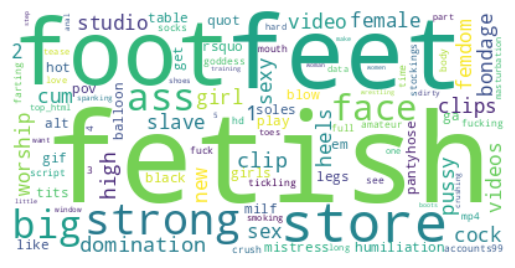

In [35]:
from wordcloud import *
word_freq = [i for i in fd.most_common(100)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [36]:
tokens_by_topic = []
for topic in df['labels'].unique():
    tokens = []
    sample = df[df['labels'] == topic]
    for i in range(len(sample)):
        tokens += sample.text.iloc[i].split()
    tokens_by_topic.append(tokens)

In [37]:
df['labels'].unique()

array([0, 1], dtype=int8)

In [38]:
event_id = 1
df['labels'].unique()[event_id]

1

In [39]:
%%time
import nltk
from nltk import *
N_best = 100 # число извлекаемых биграмм

bigram_mesures = nltk.collocations.BigramAssocMeasures() # класс для мер ассоциации биграмм
finder = BigramCollocationFinder.from_words(tokens_by_topic[event_id]) # класс для хранения и извлечение биграм
finder.apply_freq_filter(3) # избавимся от биграм, которые встречаются реже 3 раз
raw_freq_ranking = [' '.join(i) for i in finder.nbest(bigram_mesures.raw_freq, N_best)] # выбираем топ 10 биграм по частоте
tscore_ranking = [' '.join(i) for i in finder.nbest(bigram_mesures.student_t, N_best)] # выбираем топ 10 биграм по категориям
pmi_ranking = [' '.join(i) for i in finder.nbest(bigram_mesures.pmi, N_best)]
llr_ranking = [' '.join(i) for i in finder.nbest(bigram_mesures.likelihood_ratio, N_best)]
chi2_ranking = [' '.join(i) for i in finder.nbest(bigram_mesures.chi_sq, N_best)]

CPU times: user 1.59 s, sys: 25.6 ms, total: 1.62 s
Wall time: 1.65 s


In [40]:
rankings = pd.DataFrame({'chi2': chi2_ranking, 'llr': llr_ranking, 't-score': tscore_ranking, 'pmi': pmi_ranking, 'raw': raw_freq_ranking})
rankings = rankings[['raw', 'pmi', 't-score', 'chi2', 'llr']]
rankings.head(10)

,raw,pmi,t-score,chi2,llr
0,window status,12414 20808,window status,0161 0162,window status
1,return true,12502 12479,return true,11cf 96b8,return true
2,foot fetish,20and 20posts,foot fetish,11d3 b153,pedal pumping
3,blow bubble,36015 34101,blow bubble,12414 20808,high heels
4,high heels,6244 fiona3bx,high heels,12429 12400,onmouseover window
5,pedal pumping,754 209,pedal pumping,12439 12438,onmouseout window
6,onmouseover window,7665 j4j,onmouseover window,124538804310 promocode,true onmouseout
7,status return,8081 newgsbanner_468x60_5,status return,12502 12479,blow bubble
8,onmouseout window,8boll tausta,onmouseout window,152187 veggiebabyy,thigh highs
9,true onmouseout,_id b2bkvids,true onmouseout,188173 cocky,status return


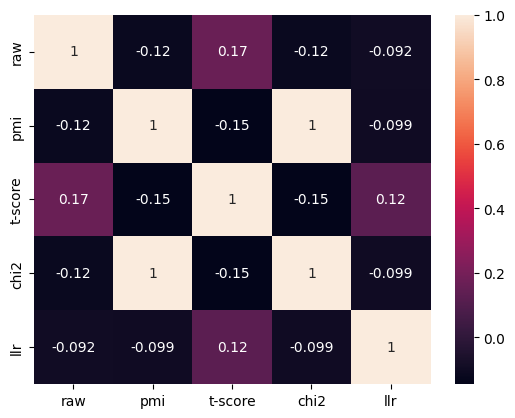

In [41]:
from scipy.stats import spearmanr
import seaborn as sns
%matplotlib inline

corr = spearmanr(rankings).correlation
sns.heatmap(corr, annot=True, xticklabels = list(rankings), yticklabels = list(rankings));

In [42]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [43]:
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [44]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

In [48]:
from xgboost import XGBClassifier
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [49]:
# label_mapping = data['labels'].cat.categories
# data['labels'] = data['labels'].cat.codes
# X = data['texts']
# y = data['labels']

In [50]:
test_size = 0.2
random_state = 1234

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y)

# val_size = 0.1
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=val_size, random_state=random_state, stratify=y_train)